<a href="https://colab.research.google.com/github/CorsiDanilo/big-data-computing-project/blob/main/1_Data_cleaning_%2B_exploration_%2B_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bitcoin price forecasting with PySpark
## Big Data Computing final project - A.Y. 2022 - 2023
Prof. Gabriele Tolomei

MSc in Computer Science

La Sapienza, University of Rome

### Author
Corsi Danilo - corsi.1742375@studenti.uniroma1.it



### Introduction

The cryptocurrency Bitcoin has attracted the attention of many people in recent years. However, it's
price fluctuation can be extremely unpredictable, which makes it difficult to predict when the right
time to buy or sell this digital currency will be. In this context, forecasting Bitcoin prices can be a
competitive advantage for investors and traders, as it could allow them to make informed decisions
on the right time to enter or exit the market. In this project, I will analyze some machine learning
techniques to understand, through the processing of historical data, how accurately the price of Bitcoin
can be predicted and whether this can provide added value to cryptocurrency investors and traders.
### Dataset
I chose to use the following dataset from Kaggle Bitcoin Historical Dataset, more specifically those
containing minute-by-minute updates of the Bitcoin price from 2017 to 2021 (period for which there
were moments of high volatility but also a lot of price lateralisation). The columns (features) contained
in it, in addition to the timestamp of each transaction, are the opening, closing, highest and lowest
price and the corresponding trading volume in Bitcoin and Dollars.
### Methods
TODO: da scegliere in base a quelli implementati❗

The methods I will test will be Linear Regression (simple and multiple) and Random Forest. Further
comparisons with other classification models are planned in the course of development. Moreover, I
would also like to try to understand what the differences are between these methods and the imple-
mentation of a state-of-the-art neural network such as Long-Short Term Memory.
### Evaluation framework
TODO: vedi quali usare in base ai paper/esempi e ai modelli utilizzati ❗

As evaluation framework I will use R-square (R²), Mean Square Error (MSE) and Mean Absolute
Error (MAE) to get a complete picture of the performance of the various models.

# Global Constants


In [1]:
JAVA_HOME = "/usr/lib/jvm/java-8-openjdk-amd64"
GDRIVE_DIR = "/content/drive"

GDRIVE_DATASET_RAW_DIR = GDRIVE_DIR + "/MyDrive/BDC/project/datasets/raw"
GDRIVE_DATASET_TEMP_DIR = GDRIVE_DIR + "/MyDrive/BDC/project/datasets/temp"
GDRIVE_DATASET_OUTPUT_DIR = GDRIVE_DIR + "/MyDrive/BDC/project/datasets/output"

GDRIVE_DATASET_NAME = "bitcoin_blockchain_data"

GDRIVE_DATASET_NAME_EXT = "/" + GDRIVE_DATASET_NAME + ".csv"

GDRIVE_DATASET = GDRIVE_DATASET_RAW_DIR + GDRIVE_DATASET_NAME_EXT

SLOW_OPERATION = False

#  Import useful Python packages

In [2]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from itertools import cycle

import plotly.express as px

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import gc

# **Spark + Google Colab Setup**

## Install PySpark and related dependencies





In [3]:
!pip install pyspark
# Alternatively, if you want to install a specific version of pyspark:
#!pip install pyspark==3.2.1
!pip install -U -q PyDrive # To use files that are stored in Google Drive directly (e.g., without downloading them from an external URL)
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = JAVA_HOME

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

from pyspark.sql import functions as F

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285398 sha256=b1c061689feffcdc36958d8c01c77cf0fb3887fbff6a2c524367f2b56274e4f9
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 15 not upgraded.
Need to get 36.5 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Selecting previously unselected package libxtst6:a

##  Create Spark context

In [4]:
# Create the session
conf = SparkConf().\
                set('spark.ui.port', "4050").\
                set('spark.executor.memory', '4G').\
                set('spark.driver.memory', '45G').\
                set('spark.driver.maxResultSize', '10G').\
                setAppName("BitcoinPriceForecasting").\
                setMaster("local[*]")

# Create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

##  Link Colab to our Google Drive

In [5]:
# Point Colaboratory to our Google Drive

from google.colab import drive

drive.mount(GDRIVE_DIR, force_remount=True)

Mounted at /content/drive


# **Data cleaning, exploration and feature selection**

In this section we are going to explore the dataset, to clean it from null values, and to determine which features are relevant and which are not.

##  Data cleaning

First, we import the dataset from Google Drive.

In [6]:
# load dataset into pyspark dataset objects
df = spark.read.load(GDRIVE_DATASET,
                         format="csv",
                         sep=",",
                         inferSchema="true",
                         header="true"
                    )

Check the shape and print out the schema of the loaded dataset

In [7]:
if SLOW_OPERATION:
  print("The shape of the dataset is {:d} rows by {:d} columns".format(df.count(), len(df.columns)))
  df.printSchema()
  df.show(5)

TODO: da sistemare ❗


Brief description of the dataset:

Contains **2675301** records of bitcoin historical data from 2017 to 2021; each record, contains the following set of **9** columns:

* Unix Timestamp - This is the unix timestamp or also known as "Epoch Time";
* Date - This timestamp is UTC Timezone;
* Symbol - The symbol for which the timeseries data refers;
* Open - This is the opening price of the time period;
* High - This is the highest price of the time period;
* Low - This is the lowest price of the time period;
* Close - This is the closing price of the time period;
* Volume (Crypto) - This is the volume in the transacted Ccy. Ie. For BTC/USDT, this is in BTC amount;
* Volume Base Ccy - This is the volume in the base/converted ccy. Ie. For BTC/USDT, this is in USDT amount;

We can delete the "symbol" and "unix" columns since we are not gonna use it and we standardize the "Volume BTC" and "Volume USD" columsn

We also check if there are any null values and reduce the columns in the dataset to two decimal places except for the btc volume.


In [8]:
# TODO: da sistemare (in base al dataset utilizzato) ❗

def data_cleaning(dataset):
  from pyspark.sql.functions import from_unixtime, to_timestamp

  # Here we standardize the columns and drop the ones we don't need
  dataset = dataset.withColumnRenamed("Timestamp","timestamp")

  # Here we reduce the columns to two decimal places
  # dataset = reduce_to_two_decimal_places(dataset)

  # Here we  check if there are any null values
  if SLOW_OPERATION:
    for c in dataset.columns:
      print("N. of missing values of column `{:s}` = {:d}".format(c, dataset.where(col(c).isNull()).count()))

    dataset.show(5)

  return dataset

In [9]:
def reduce_to_two_decimal_places(dataset):
  dataset = dataset.withColumn("open", round(dataset["open"], 2)) \
                  .withColumn("close", round(dataset["close"], 2)) \
                  .withColumn("high", round(dataset["high"], 2)) \
                  .withColumn("low", round(dataset["low"], 2)) \
                  .withColumn("volume_usd", round(dataset["volume_usd"], 2)
                )

  return dataset

In [10]:
df = data_cleaning(df)

##  Exploring the data
Before building a model to forecast the Bitcoin price, let's try to have a better visualization of the dataset

In [11]:
def compute_daily_df(dataset):
  # Calculation of the average values and volume for each day
  # TODO: da sistemare❗
  dataset = dataset.withColumn("timestamp", date_format(dataset.timestamp, "yyyy-MM-dd")).groupBy("timestamp").agg(
      avg("market-price").alias("market-price"),
      avg("total-bitcoins").alias("total-bitcoins"),
      avg("market-cap").alias("market-cap"),
      avg("trade-volume").alias("trade-volume"),
      avg("blocks-size").alias("blocks-size"),
      avg("avg-block-size").alias("avg-block-size"),
      avg("n-transactions-total").alias("n-transactions-total"),
      avg("n-transactions-per-block").alias("n-transactions-per-block"),
      avg("hash-rate").alias("hash-rate"),
      avg("difficulty").alias("difficulty"),
      avg("miners-revenue").alias("miners-revenue"),
      avg("transaction-fees-usd").alias("transaction-fees-usd"),
      avg("n-unique-addresses").alias("n-unique-addresses"),
      avg("n-transactions").alias("n-transactions"),
      avg("estimated-transaction-volume-usd").alias("estimated-transaction-volume-usd")
  ).sort("timestamp")

  # Reduce the columns in the dataset to two decimal places
  # dataset = reduce_to_two_decimal_places(dataset)

  if SLOW_OPERATION:
    print("The shape of the dataset is {:d} rows by {:d} columns".format(dataset.count(), len(dataset.columns)))
    dataset.show(5)

  # convert the dataset from PySpark to Pandas
  return dataset.toPandas()

In [12]:
daily_df = compute_daily_df(df)
daily_df

,timestamp,market-price,total-bitcoins,market-cap,trade-volume,blocks-size,avg-block-size,n-transactions-total,n-transactions-per-block,hash-rate,difficulty,miners-revenue,transaction-fees-usd,n-unique-addresses,n-transactions,estimated-transaction-volume-usd
0,2012-01-01,5.154920,8.007621e+06,4.127931e+07,0.000000e+00,863.243723,0.018096,2.122347e+06,34.255954,8.677831e+00,1.159929e+06,5.280242e+04,27.246788,8729.362153,5205.357986,8.835884e+05
1,2012-01-02,5.359937,8.013350e+06,4.223035e+07,0.000000e+00,865.995745,0.018667,2.127531e+06,36.067829,9.052484e+00,1.159929e+06,5.482596e+04,33.276612,9227.791667,5591.373958,6.773917e+05
2,2012-01-03,5.410028,8.019221e+06,4.266227e+07,0.000000e+00,868.909226,0.018781,2.133103e+06,37.384883,9.110505e+00,1.159929e+06,4.684667e+04,54.304947,9534.995139,5752.014583,6.766216e+05
3,2012-01-04,5.584851,8.030971e+06,4.485304e+07,0.000000e+00,871.809321,0.022012,2.138894e+06,43.017494,8.678032e+00,1.159929e+06,5.037784e+04,61.401578,10588.272917,6362.061458,1.181757e+06
4,2012-01-05,6.199722,8.042471e+06,4.986334e+07,0.000000e+00,875.047887,0.023216,2.145257e+06,43.219046,9.138714e+00,1.159929e+06,5.706349e+04,45.826454,11346.701042,6819.121528,1.385242e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4012,2022-12-26,16871.249153,1.924388e+07,3.240861e+11,3.354497e+07,445087.078471,1.247745,7.910570e+08,1906.864769,2.144793e+08,3.536407e+13,1.329749e+07,348679.441564,571121.583333,231425.994792,1.036960e+09
4013,2022-12-27,16807.425243,1.924450e+07,3.223369e+11,6.157398e+07,445238.664333,1.201487,7.912897e+08,1853.198090,2.487186e+08,3.536407e+13,1.516539e+07,372493.264356,627257.427778,256142.336806,1.583269e+09
4014,2022-12-28,16619.195458,1.924574e+07,3.204609e+11,8.845891e+07,445404.121387,1.144686,7.915467e+08,1755.360249,2.716209e+08,3.536407e+13,1.641191e+07,343124.000164,664779.030208,269454.428472,2.052488e+09
4015,2022-12-29,16584.853330,1.924697e+07,3.199331e+11,7.873554e+07,445579.167519,1.309789,7.918155e+08,1864.051777,2.628042e+08,3.536407e+13,1.584562e+07,351266.799392,697211.435069,278476.298611,2.644073e+09


In [18]:
def show_currency_statistics(dataset):
  trace1 = go.Scatter(
      x = dataset['timestamp'],
      y = dataset['market-price'].astype(float),
      mode = 'lines',
      name = 'Market Price'
  )
  trace2 = go.Scatter(
      x = dataset['timestamp'],
      y = dataset['market-cap'].astype(float),
      mode = 'lines',
      name = 'Market capitalization'
  )
  trace3 = go.Scatter(
      x = dataset['timestamp'],
      y = dataset['total-bitcoins'].astype(float),
      mode = 'lines',
      name = 'Total bitcoins'
  )
  trace4 = go.Scatter(
      x = dataset['timestamp'],
      y = dataset['trade-volume'].astype(float),
      mode = 'lines',
      name = 'Trade volume'
  )

  layout = dict(
      title='Currency statistics',
      xaxis=dict(
          rangeselector=dict(
              buttons=list([
                  #change the count to desired amount of months.
                  dict(count=1,
                      label='1m',
                      step='month',
                      stepmode='backward'),
                  dict(count=6,
                      label='6m',
                      step='month',
                      stepmode='backward'),
                  dict(count=12,
                      label='1y',
                      step='month',
                      stepmode='backward'),
                  dict(count=36,
                      label='3y',
                      step='month',
                      stepmode='backward'),
                  dict(step='all')
              ])
          ),
          rangeslider=dict(
              visible = True
          ),
          type='date'
      )
  )

  data = [trace1, trace2, trace3, trace4]
  fig = dict(data=data, layout=layout)
  iplot(fig, filename = "Time Series with Rangeslider")

In [14]:
def show_blockchain_details(dataset):
  trace1 = go.Scatter(
      x = dataset['timestamp'],
      y = dataset['blocks-size'].astype(float),
      mode = 'lines',
      name = 'Total blochain size'
  )
  trace2 = go.Scatter(
    x = dataset['timestamp'],
    y = dataset['avg-block-size'].astype(float),
    mode = 'lines',
    name = 'Avg block size'
  )

  trace3 = go.Scatter(
    x = dataset['timestamp'],
    y = dataset['n-transactions-total'].astype(float),
    mode = 'lines',
    name = 'N total transactions'
  )

  trace4 = go.Scatter(
    x = dataset['timestamp'],
    y = dataset['n-transactions-per-block'].astype(float),
    mode = 'lines',
    name = 'N transactions per block'
  )

  layout = dict(
      title='Blockchain details',
      xaxis=dict(
          rangeselector=dict(
              buttons=list([
                  dict(count=1,
                      label='1m',
                      step='month',
                      stepmode='backward'),
                  dict(count=6,
                      label='6m',
                      step='month',
                      stepmode='backward'),
                  dict(count=12,
                      label='1y',
                      step='month',
                      stepmode='backward'),
                  dict(count=36,
                      label='3y',
                      step='month',
                      stepmode='backward'),
                  dict(step='all')
              ])
          ),
          rangeslider=dict(
              visible = True
          ),
          type='date'
      )
  )

  data = [trace1, trace2, trace3, trace4]
  fig = dict(data=data, layout=layout)
  iplot(fig, filename = "Time Series with Rangeslider")

In [15]:
def show_mining_information(dataset):
  trace1 = go.Scatter(
      x = dataset['timestamp'],
      y = dataset['hash-rate'].astype(float),
      mode = 'lines',
      name = 'hash-rate'
  )
  trace2 = go.Scatter(
    x = dataset['timestamp'],
    y = dataset['difficulty'].astype(float),
    mode = 'lines',
    name = 'difficulty'
  )

  trace3 = go.Scatter(
    x = dataset['timestamp'],
    y = dataset['miners-revenue'].astype(float),
    mode = 'lines',
    name = 'miners-revenue'
  )

  trace4 = go.Scatter(
    x = dataset['timestamp'],
    y = dataset['transaction-fees-usd'].astype(float),
    mode = 'lines',
    name = 'transaction-fees-usd'
  )

  layout = go.Layout(
      title='BTC Volume v/s USD',
      xaxis=dict(
          title='Close Price',
          titlefont=dict(
              family='Courier New, monospace',
              size=18,
              color='#7f7f7f'
          )
      ),
      yaxis=dict(
          title='Mining information',
          titlefont=dict(
              family='Courier New, monospace',
              size=18,
              color='#7f7f7f'
          )))
  data = [trace1, trace2, trace3, trace4]
  fig = go.Figure(data=data, layout=layout)
  iplot(fig, filename='Time Series with Rangeslider')

In [16]:
def show_network_activity(dataset):
  trace1 = go.Scatter(
      x = dataset['timestamp'],
      y = dataset['n-unique-addresses'].astype(float),
      mode = 'lines',
      name = 'n-unique-addresses'
  )
  trace2 = go.Scatter(
    x = dataset['timestamp'],
    y = dataset['n-transactions'].astype(float),
    mode = 'lines',
    name = 'n-transactions'
  )

  trace3 = go.Scatter(
    x = dataset['timestamp'],
    y = dataset['estimated-transaction-volume-usd'].astype(float),
    mode = 'lines',
    name = 'estimated-transaction-volume-usd'
  )

  layout = go.Layout(
      title='Network activity',
      xaxis=dict(
          title='Close Price',
          titlefont=dict(
              family='Courier New, monospace',
              size=18,
              color='#7f7f7f'
          )
      ),
      yaxis=dict(
          title='Mining information',
          titlefont=dict(
              family='Courier New, monospace',
              size=18,
              color='#7f7f7f'
          )))
  data = [trace1, trace2, trace3]
  fig = go.Figure(data=data, layout=layout)
  iplot(fig, filename='Time Series with Rangeslider')

In [19]:
show_currency_statistics(daily_df)

In [20]:
show_blockchain_details(daily_df)

In [21]:
show_mining_information(daily_df)

In [22]:
show_network_activity(daily_df)

##  Feature Selection

The aim of this section is to remove the features that have less of an impact to the final result from the dataset. This operation is called feature selection. Let's plot a correlation map to see how features are correlated among each other:

In [ ]:
def feature_selection(dataset):
  import seaborn as sns

  correlation_matrix = dataset.corr()
  plt.figure(figsize = (10, 6))
  sns.heatmap(correlation_matrix, annot=True, cmap='BuPu', fmt=".1f")

  plt.show()

<ipython-input-41-13cf72aab94d>:4: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



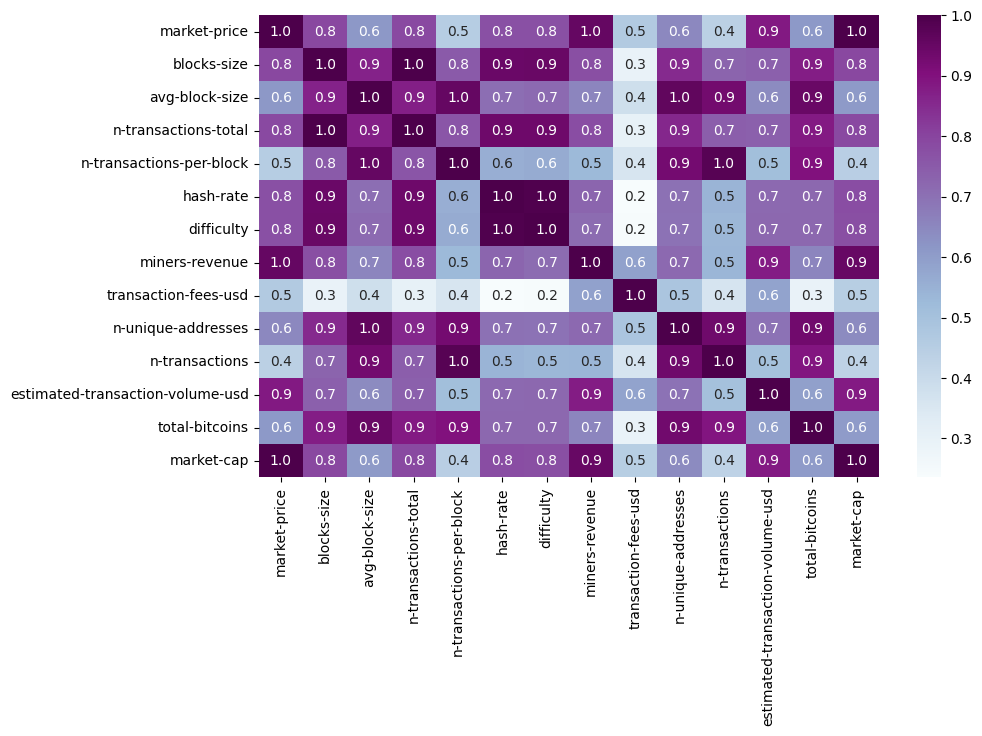

In [ ]:
feature_selection(daily_df)

Here we can observe that, the high, low, open and close are the almost correlate features, so for price forecasting, we can drop all of them from the original dataset except for the closing price.
Also we can drop volume_btc and volume_usd since we are not gonna use it.

Selected Features
- Close Price
- Volume USD

In [ ]:
def dropping_columns(dataset):
  dataset = dataset.drop("high") \
        .drop("low") \
        .drop("open") \
        .drop("volume_btc")

  if SLOW_OPERATION:
    dataset.printSchema()
    dataset.show(5)

  return dataset

In [ ]:
df = dropping_columns(df)

## Stationarity and detrending (ADF/KPSS)

Source: https://www.kaggle.com/code/debashis74017/time-series-forecasting-itcoin-price?scriptVersionId=113747601&cellId=25

Stationarity means that the statistical properties of a time series i.e. mean, variance and covariance do not change over time. Many statistical models require the series to be stationary to make effective and precise predictions.

Two statistical tests would be used to check the stationarity of a time series – Augmented Dickey Fuller (“ADF”) test and Kwiatkowski-Phillips-Schmidt-Shin (“KPSS”) test. A method to convert a non-stationary time series into stationary series shall also be used.

### ADF Test
ADF test is used to determine the presence of unit root in the series, and hence helps in understand if the series is stationary or not. The null and alternate hypothesis of this test are:

Null Hypothesis: The series has a unit root.

Alternate Hypothesis: The series has no unit root.

If the null hypothesis in failed to be rejected, this test may provide evidence that the series is non-stationary.

In [ ]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(daily_df.close.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -1.664252973153243
p-value: 0.4496180967923234
Critial Values:
   1%, -3.4328350737532487
Critial Values:
   5%, -2.8626379169370946
Critial Values:
   10%, -2.5673544595439926


ADF Stats value is greater than all critical values, and p-value is also greater than 0.05. So we can strongly reject the null hypothesis, and conclude that, Price value is Non-Stationary.

Let's apply log transformation to the data and test again

In [ ]:
from numpy import log

result = adfuller((log(daily_df.close.values)), autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -2.1720345632051243
p-value: 0.21655137700780686
Critial Values:
   1%, -3.4328107600573845
Critial Values:
   5%, -2.8626271794692513
Critial Values:
   10%, -2.567348742862796


After applying Log transformation also, ADF Stats value is greater than all critical values, and p-value is also greater than 0.05. It seems, Price value is purely Non-Stationary.

### KPSS test - Kwiatkowski Phillips Schmidt Shin
KPSS is another test for checking the stationarity of a time series. The null and alternate hypothesis for the KPSS test are opposite that of the ADF test.

Null Hypothesis: The process is trend stationary.

Alternate Hypothesis: The series has a unit root (series is not stationary).

In [ ]:
from statsmodels.tsa.stattools import kpss

result = kpss(daily_df['close'].values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}');


KPSS Statistic: 5.311764
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




The output of the KPSS test contains 4 things:

1. The KPSS statistic
2. p-value
3. Number of lags used by the test
4. Critical values

The p-value reported by the test is the probability score based on which you can decide whether to reject the null hypothesis or not. If the p-value is less than a predefined alpha level (typically 0.05), we reject the null hypothesis.

The KPSS statistic is the actual test statistic that is computed while performing the test.

In order to reject the null hypothesis, the test statistic should be greater than the provided critical values. If it is in fact higher than the target critical value, then that should automatically reflect in a low p-value.

That is, if the p-value is less than 0.05, the kpss statistic will be greater than the 5% critical value.

Finally, the number of lags reported is the number of lags of the series that was actually used by the model equation of the kpss test. By default, the statsmodels kpss() uses the ‘legacy’ method. In legacy method, int(12 * (n / 100)**(1 / 4)) number of lags is included, where n is the length of the series.

Here we find that, KPSS stats value is too high than critical values.

So, we concluded that this time series is Non-Stationary

# Output

Saving the final dataset and moving it to the root folder

In [ ]:
def output(dataset):
  from pyspark.sql.functions import date_format, to_timestamp, col

  # transform date column into string
  dataset = dataset.withColumn("date", to_timestamp(col("date"), "yyyy-MM-dd HH:mm:ss").cast("string"))

  # save the dataset in CSV format
  dataset.repartition(1).write.csv(GDRIVE_DATASET_TEMP_DIR, header=True, mode='overwrite')

  import os
  import glob
  import time

  while True:
      csv_files = glob.glob(os.path.join(GDRIVE_DATASET_TEMP_DIR, "part*.csv"))
      if len(csv_files) > 0:
          # .csv file found!
          file_path = csv_files[0]
          break
      else:
          print(".csv file not found. I'll try again after 1 second...")
          time.sleep(1)

  print(".csv file found:", file_path)

  new_file_path = GDRIVE_DATASET_OUTPUT_DIR + "/" + GDRIVE_DATASET_NAME + "_cleaned.csv"

  import shutil

  # rename and move the file
  shutil.move(file_path, new_file_path)

  print("File renamed and moved successfully!")

In [ ]:
output(df)

.csv file found: /content/drive/MyDrive/BDC/project/datasets/temp/part-00000-086a228a-4057-4b9e-ac3b-2f48cf62e356-c000.csv
File renamed and moved successfully!
